In [1]:
from typing import Any, OrderedDict, List, Dict
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
import json
from torchmetrics import Accuracy
from lightly.transforms.utils import IMAGENET_NORMALIZE
from PIL import Image

## Load Data

In [2]:
class ImageDataset(Dataset):
    def __init__(self, set_map: List[Dict], transform=None) -> None:
        ''' Each item in set_map is expected to contain:
                img_path: Full path to image,
                label: Label corresponding to image at img_path
        '''

        self.set_map = set_map
        self.transform=transform

    def __len__(self):
        return len(self.set_map)
    
    def __getitem__(self, index):   
        sample = self.set_map[index]

        # image = read_image(sample['img_path'])
        image = Image.open(sample['img_path'])

        if self.transform:
            image = self.transform(image)

        return dict(image=image, **sample)

In [3]:
with open('./data/train_unbalanced_1_20.json', 'r') as file:
    train_set_map = json.load(file)

In [4]:
with open('./data/test_unbalanced.json', 'r') as file:
    test_set_map = json.load(file)

In [5]:
label_map = {
    'DG': 0,
    'PH': 1,
    'EH': 2,
    'G': 3
}

domain_map = {
    'cartoon': 0,
    'art_painting': 1,
    'photo': 2,
}

In [6]:
for elem in train_set_map:
    elem['label'] = label_map[elem['label']]
for elem in test_set_map:
    elem['label'] = label_map[elem['label']]

In [7]:
transform = T.Compose([
    T.Resize(96),
    T.ToTensor(),
    T.Normalize(
        mean=IMAGENET_NORMALIZE["mean"],
        std=IMAGENET_NORMALIZE["std"],
    ),
])

/home/yasin/miniforge3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
train_set = ImageDataset(train_set_map, transform=transform)
test_set = ImageDataset(test_set_map, transform=transform)

In [9]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

## Validate Data

In [10]:
stats = {}
for elem in train_set_map:
    domain = elem['domain']
    label = elem['label']

    if domain not in stats.keys() :
        stats[domain] = {}

    if label not in stats[domain].keys():
        stats[domain][label] = 1
    else:
        stats[domain][label] += 1

In [11]:
stats

{'photo': {1: 585, 2: 10, 0: 10, 3: 10},
 'cartoon': {2: 585, 0: 10, 1: 10, 3: 10},
 'sketch': {3: 550, 0: 10, 2: 10, 1: 10},
 'art_painting': {0: 585, 3: 10, 1: 10, 2: 10}}

In [12]:
stats = {}
for elem in test_set_map:
    domain = elem['domain']
    label = elem['label']

    if domain not in stats.keys() :
        stats[domain] = {}

    if label not in stats[domain].keys():
        stats[domain][label] = 1
    else:
        stats[domain][label] += 1

In [13]:
stats

{'art_painting': {1: 74, 2: 48, 0: 79, 3: 16},
 'sketch': {0: 144, 3: 58, 2: 145, 1: 19},
 'photo': {2: 37, 1: 65, 0: 47, 3: 19},
 'cartoon': {0: 83, 2: 78, 3: 12, 1: 76}}

## Train Models

In [14]:
import pytorch_lightning as L

In [15]:
from typing import Any


class LinearProbe(L.LightningModule):
    def __init__(self, backbone, emb_dim, num_classes, lr=1e-2) -> None:
        super().__init__()
        
        self.backbone: nn.Module = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.linear_head: nn.Module = nn.Linear(emb_dim, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

        self.test_accuracy = Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.linear_head(x)

        return x

    def training_step(self, batch, bacth_idx):
        X = batch['image']
        t = batch['label']

        y = self.forward(X)
        loss = self.criterion(y, t)

        print(loss.item())

        return loss
    
    def test_step(self, batch, batch_idx):
        X = batch['image']
        t = batch['label']

        y = self.forward(X)
        acc = self.test_accuracy(y, t)

        self.log('accuracy', acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.linear_head.parameters(), lr=self.lr)

In [16]:
def get_backbone_from_ckpt(ckpt_path: str) -> torch.nn.Module:
    state_dict = torch.load(ckpt_path)["state_dict"]
    state_dict = OrderedDict([
        (".".join(name.split(".")[1:]), param) for name, param in state_dict.items() if name.startswith("backbone")
    ])

    return state_dict

In [17]:
# Baseline Model
model_bl  = resnet50(weights=ResNet50_Weights.DEFAULT)
weights_bl = get_backbone_from_ckpt("./data/r50_bl.ckpt")
# model_bl.load_state_dict(weights_bl, strict=False)
model_bl.fc = torch.nn.Identity()
model_bl = model_bl.cuda()

In [18]:
# MixStyle Model
model_ms  = resnet50()
weights_ms = get_backbone_from_ckpt("./data/r50_dann.ckpt")
model_ms.load_state_dict(weights_ms, strict=False)
model_ms.fc = torch.nn.Identity()
model_ms = model_ms.cuda()

In [18]:
baseline_module = LinearProbe(model_bl, emb_dim=2048, num_classes=4)

In [19]:
mixstyle_module = LinearProbe(model_ms, emb_dim=2048, num_classes=4)

In [19]:
trainer = L.Trainer(
    max_epochs=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(baseline_module, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | backbone      | ResNet             | 23.5 M
1 | linear_head   | Linear             | 8.2 K 
2 | criterion     | CrossEntropyLoss   | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
8.2 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.065    Total estimated model params size (MB)
/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

1.4980906248092651
0.489188551902771
0.23804907500743866
0.2060573846101761
0.18815967440605164
0.2007211446762085
0.24026283621788025
0.2073250412940979
0.24554221332073212
0.07828708738088608
0.08798308670520782
0.11245448887348175
0.17103269696235657
0.10084700584411621
0.10455027222633362
0.04959710314869881
0.08136055618524551
0.10951956361532211
0.12189077585935593
0.11168702691793442
0.04385114461183548
0.07267758250236511
0.03534652292728424
0.05810139700770378
0.04832335561513901
0.062247566878795624
0.04270501807332039
0.03638991340994835
0.0704009011387825
0.04956631362438202
0.050413720309734344
0.031406838446855545
0.03559036925435066
0.024529272690415382
0.04849286749958992
0.017841888591647148
0.011220627464354038
0.01898515410721302
0.02242429368197918
0.044940680265426636
0.0160013809800148
0.0133542874827981
0.01292035449296236
0.020116811618208885
0.008977741003036499
0.012708618305623531
0.024395043030381203
0.015592947602272034
0.010603571310639381
0.02802118845283

`Trainer.fit` stopped: `max_epochs=10` reached.


0.00394904101267457


In [21]:
trainer.test(baseline_module, dataloaders=train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 121. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │            1.0            │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 1.0}]

In [22]:
trainer.test(baseline_module, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 232. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.593000054359436     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.593000054359436}]

In [20]:
trainer = L.Trainer(
    max_epochs=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(mixstyle_module, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | backbone      | ResNet             | 23.5 M
1 | linear_head   | Linear             | 8.2 K 
2 | criterion     | CrossEntropyLoss   | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
8.2 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.065    Total estimated model params size (MB)
/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

1.4245569705963135
0.7684281468391418
0.7430567145347595
0.27111518383026123
0.27014222741127014
0.20921984314918518
0.5189310908317566
0.12820370495319366
0.13010798394680023
0.13689343631267548
0.09682818502187729
0.1723729968070984
0.17784857749938965
0.3498452305793762
0.10871981829404831
0.060942597687244415
0.13591457903385162
0.1077226996421814
0.1859731674194336
0.12878021597862244
0.14522038400173187
0.09703531861305237
0.13463062047958374
0.14505799114704132
0.059809718281030655
0.03392831236124039
0.09599816054105759
0.38161924481391907
0.1298106461763382
0.06902503222227097
0.049620579928159714
0.1133297011256218
0.07485751807689667
0.09073793888092041
0.657452404499054
0.058018408715724945
0.05097671225667
0.1041077971458435
0.04067360609769821
0.040155380964279175
0.016292821615934372
0.37527555227279663
0.026651808992028236
0.039364371448755264
0.021908704191446304
0.03352019935846329
0.052340760827064514
0.030159998685121536
0.06262195110321045
0.082260362803936
0.09562

`Trainer.fit` stopped: `max_epochs=10` reached.


In [22]:
trainer.test(mixstyle_module, dataloaders=train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 121. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9979381561279297     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.9979381561279297}]

In [23]:
trainer.test(mixstyle_module, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/home/yasin/miniforge3/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 232. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.718000054359436     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.718000054359436}]

In [29]:
import matplotlib.pyplot as plt

In [30]:
baseline_scores = [88.2, 77.6, 70.9, 68.6]
mixstyel_scores = [89.5, 79.6, 76.1, 72.5]

Text(0.5, 1.0, 'Unbalanced Linear Probing')

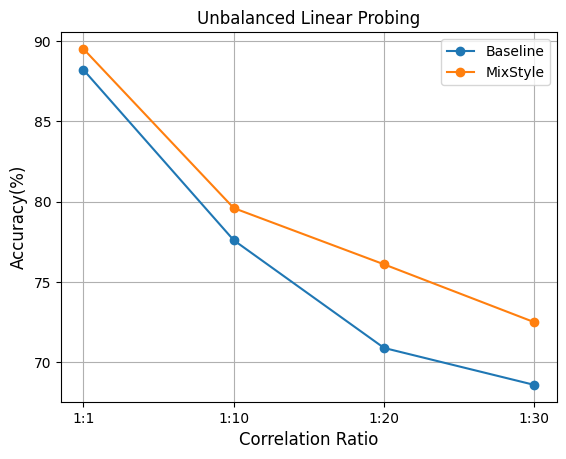

In [31]:
plt.plot(baseline_scores, label='Baseline', marker='o')
plt.plot(mixstyel_scores, label='MixStyle', marker='o')
plt.xticks([0, 1, 2, 3], ['1:1', '1:10', '1:20', '1:30'],
       rotation=0)  # Set text labels and properties.
plt.legend()
plt.xlabel('Correlation Ratio', fontsize=12)
plt.ylabel('Accuracy(%)', fontsize=12)
plt.grid()
plt.title('Unbalanced Linear Probing')